<a href="https://colab.research.google.com/github/breno-gabriel/Intrusion-Detection-/blob/main/Copy_of_Aula_Pr%C3%A1tica_3_Autoencoders_%5BN%C3%A3o_Resolvido%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas

In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
sns.set_theme()

In [ ]:
RANDOM_SEED = 33
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Download CIC IDS 2017

[Este](https://www.unb.ca/cic/datasets/ids-2017.html) conjunto de dados contém informações sobre fluxos de rede, representando tanto o tráfego benigno quanto ataques populares. Para o ambiente de teste desta coleta de dados, uma rede foi configurada para o atacante e uma rede separada foi configurada para as vítimas, esta última contendo firewalls, roteadores, switches, servidores e estações de trabalho em execução em diferentes versões dos sistemas operacionais Windows e Linux. Para gerar o tráfego benigno, os autores utilizaram um sistema desenvolvido por eles mesmos, que então extraiu o comportamento abstrato de 25 usuários com base em diferentes protocolos de aplicação. Os dados foram coletados ao longo de cinco dias de atividade de rede e foram processados para extrair mais de 80 features do conjunto de dados usando a ferramenta CICFlowMeter8.


In [ ]:
# update gdown version
!pip install --upgrade --no-cache-dir gdown

In [ ]:
# !wget http://205.174.165.80/CICDataset/CIC-IDS-2017/Dataset/MachineLearningCSV.zip -O CIC_IDS_2017.zip
!gdown '1WtbUHBpANHLMVVHuaFr9-pGUyeW6QhdD' -O CIC_IDS_2017.zip

Downloading...
From (original): https://drive.google.com/uc?id=1WtbUHBpANHLMVVHuaFr9-pGUyeW6QhdD
From (redirected): https://drive.google.com/uc?id=1WtbUHBpANHLMVVHuaFr9-pGUyeW6QhdD&confirm=t&uuid=21c96001-ee97-48f1-a05d-51e6a7e9bbf7
To: /content/CIC_IDS_2017.zip
100% 235M/235M [00:02<00:00, 105MB/s]


In [ ]:
# !unzip MachineLearningCSV.zip
!unzip ./CIC_IDS_2017.zip

Archive:  ./CIC_IDS_2017.zip
replace MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Carregando os dados

In [ ]:
df_list = []
for file in os.listdir('MachineLearningCVE/'):
  df_aux = pd.read_csv(f'MachineLearningCVE/{file}')
  df_list.append(df_aux)
df = pd.concat(df_list, ignore_index=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max         

In [ ]:
list(df.columns)[:6]

[' Destination Port',
 ' Flow Duration',
 ' Total Fwd Packets',
 ' Total Backward Packets',
 'Total Length of Fwd Packets',
 ' Total Length of Bwd Packets']

Algumas colunas tem seus nomes iniciados com espaços ou finalizados com espaços. Vamos remover esses espaços não úteis para ajustar o nome das colunas.

In [ ]:
df.columns = df.columns.str.strip()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Destination Port             int64  
 1   Flow Duration                int64  
 2   Total Fwd Packets            int64  
 3   Total Backward Packets       int64  
 4   Total Length of Fwd Packets  int64  
 5   Total Length of Bwd Packets  int64  
 6   Fwd Packet Length Max        int64  
 7   Fwd Packet Length Min        int64  
 8   Fwd Packet Length Mean       float64
 9   Fwd Packet Length Std        float64
 10  Bwd Packet Length Max        int64  
 11  Bwd Packet Length Min        int64  
 12  Bwd Packet Length Mean       float64
 13  Bwd Packet Length Std        float64
 14  Flow Bytes/s                 float64
 15  Flow Packets/s               float64
 16  Flow IAT Mean                float64
 17  Flow IAT Std                 float64
 18  Flow IAT Max                 int64  
 19  

# Limpando os dados

É necessário limpar os dados realizando:
- Descarte de registros duplicados
- Descarte de registros com valores NaN (Not a Number)/ Null / NA (Not Available)
- Evitar registros com valores não finitos. Nesse caso, uma abordagem válida é substituirmos os mesmos pelo maior valor finito presente no dataset.

Registros duplicados

In [ ]:
df[df.duplicated()]

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
2109,80,77,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2257,443,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2749,443,49,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2862,443,4,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2877,443,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830701,53,179,2,2,46,46,23,23,23.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830725,53,161,2,2,82,114,41,41,41.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830726,53,212,2,2,84,162,42,42,42.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830731,443,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [ ]:
# Descartando duplicadas
initial_len = df.shape[0]
df = df.drop_duplicates()
print(f'Tamanho inicial: {initial_len}, tamanho final {df.shape[0]} | Descartadas {initial_len - df.shape[0]} duplicadas')

Tamanho inicial: 2830743, tamanho final 2522362 | Descartadas 308381 duplicadas


Registros com valores Null/NaN/NA

In [ ]:
df.columns[df.isna().any(axis=0)]

Index(['Flow Bytes/s'], dtype='object')

In [ ]:
df[df.isna().any(axis=1)][['Flow Bytes/s']]

,Flow Bytes/s
6796,NaN
14739,NaN
15047,NaN
209728,NaN
225835,NaN
...,...
2740049,NaN
2767532,NaN
2791593,NaN
2809052,NaN


In [ ]:
# Descartando registros com valores NaN/Null/NA
initial_len = df.shape[0]
df = df.dropna()
print(f'Tamanho inicial: {initial_len}, tamanho final {df.shape[0]} | Descartados {initial_len - df.shape[0]} registros com valores NA')

Tamanho inicial: 2522362, tamanho final 2522009 | Descartados 353 registros com valores NA


In [ ]:
df = df.reset_index(drop=True)

Registros com valores não finitos

In [ ]:
df_columns_isfinite = np.isfinite(df.drop(['Label'], axis='columns')).all(axis=0)
df_columns_isfinite[df_columns_isfinite == False]

Flow Bytes/s      False
Flow Packets/s    False
dtype: bool

In [ ]:
df_rows_isfinite = np.isfinite(df.drop(['Label'], axis='columns')).all(axis=1)
inf_indexes = df_rows_isfinite[df_rows_isfinite == False].index
df.iloc[inf_indexes][['Flow Bytes/s', 'Flow Packets/s', 'Flow Duration']]

,Flow Bytes/s,Flow Packets/s,Flow Duration
65,inf,inf,0
1767,inf,inf,0
1890,inf,inf,0
3365,inf,inf,0
8001,inf,inf,0
...,...,...,...
2515309,inf,inf,0
2515565,inf,inf,0
2516784,inf,inf,0
2516908,inf,inf,0


In [ ]:
# Evitando registros com valores não finitos
max_finite_flow_packets_per_sec = df[np.isfinite(df['Flow Packets/s'])]['Flow Packets/s'].max()
max_finite_flow_bytes_per_sec = df[np.isfinite(df['Flow Bytes/s'])]['Flow Bytes/s'].max()

df.loc[df['Flow Packets/s'] == np.inf, 'Flow Packets/s'] = max_finite_flow_packets_per_sec
df.loc[df['Flow Bytes/s'] == np.inf, 'Flow Bytes/s'] = max_finite_flow_bytes_per_sec

# Mini análise exploratória

### Quantidade de instâncias benignas x maliciosas

<Axes: xlabel='Label', ylabel='count'>

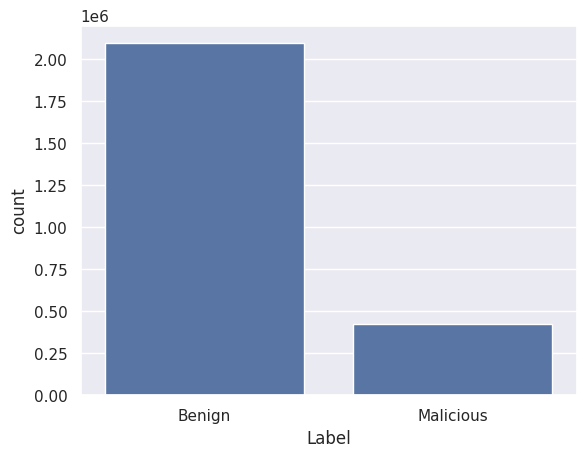

In [ ]:
sns.countplot(data=df['Label'].apply(lambda label: 'Malicious' if label != 'BENIGN' else 'Benign').to_frame(), x='Label')

**Dados não balanceados**. Impactos:
- Dificuldade de treinar modelos supervisionados
- Dificuldade de avaliar resultados com métricas tradicionais como acurácia

### Quantidade de instâncias por tipo de ataque

Abaixo está um descritivo para os ataques do dataset:

**DoS (Denial of Service)**: Esses ataques, como "DoS Hulk", "DoS GoldenEye", "DoS Slowloris", "DoS Slowhttptest" e "DDoS" visam tornar temporariamente uma máquina ou recurso de rede indisponível, sendo diferenciados pelo protocolo e estratégia usados para causar a negação de serviço. No caso do "DDoS", várias máquinas Windows 8.1 foram usadas para enviar solicitações UDP, TCP e HTTP.

**FTP Patator" e "SSH Patator**: Usam o software Patator para adivinhar senhas por força bruta com o uso de listas de palavras.

**Web - Brute Force**: Usa força bruta em uma aplicação com listas de palavras.

**Web - Injeção de SQL**: Esse ataque explora vulnerabilidades em máquinas conectadas publicamente à Internet usando injeção SQL.

**Web - XSS (Cross-Site Scripting)**: Representa injeções de scripts em aplicativos da web, visando a execução de ações maliciosas por outros usuários do aplicativo.

**PortScan**: Realizados com a ferramenta NMap, esses ataques buscam informações sobre os serviços e portas abertas em um alvo.

**Bot**: Esse ataque tem várias possibilidades, como roubo de dados, envio de spam e acesso ao dispositivo. .

**Infiltration**: Baseado na infecção de uma máquina após um usuário abrir um arquivo malicioso.

In [ ]:
df['Label'] = df['Label'].replace({'Web Attack � Brute Force':'Brute Force', 'Web Attack � XSS':'XSS', 'Web Attack � Sql Injection':'Sql Injection'})

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, 'DoS Hulk'),
  Text(1, 0, 'DDoS'),
  Text(2, 0, 'PortScan'),
  Text(3, 0, 'DoS GoldenEye'),
  Text(4, 0, 'FTP-Patator'),
  Text(5, 0, 'DoS slowloris'),
  Text(6, 0, 'DoS Slowhttptest'),
  Text(7, 0, 'SSH-Patator'),
  Text(8, 0, 'Bot'),
  Text(9, 0, 'Brute Force'),
  Text(10, 0, 'XSS'),
  Text(11, 0, 'Infiltration'),
  Text(12, 0, 'Sql Injection'),
  Text(13, 0, 'Heartbleed')])

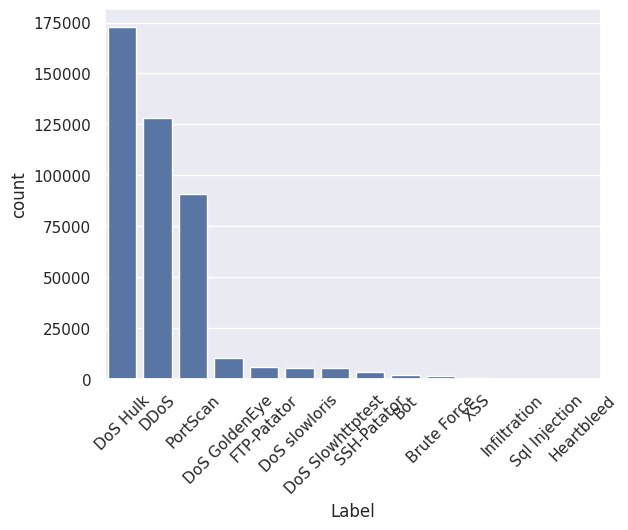

In [ ]:
sns.countplot(data=df.query('Label != "BENIGN"')[['Label']], x='Label', order = df.query('Label != "BENIGN"')['Label'].value_counts().index)
plt.xticks(rotation=45)

Ataques menos representados

([0, 1, 2, 3, 4],
 [Text(0, 0, 'Infiltration'),
  Text(1, 0, 'Brute Force'),
  Text(2, 0, 'XSS'),
  Text(3, 0, 'Sql Injection'),
  Text(4, 0, 'Heartbleed')])

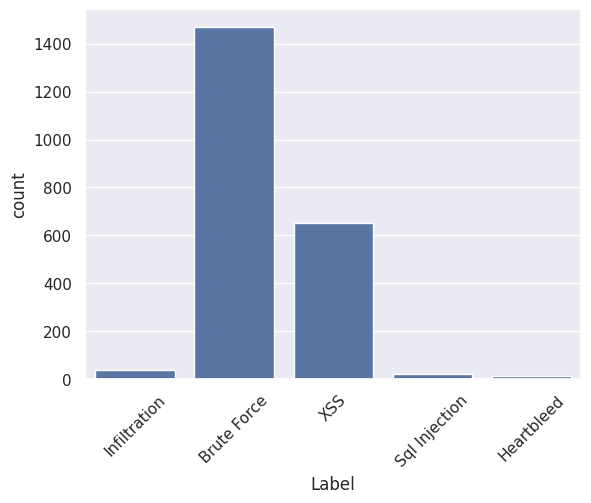

In [ ]:
N_LESS_REPRESENTED_LABELS = 5

sns.countplot(data=df[df['Label'].isin(df.groupby('Label').size().sort_values(ascending=False)[(-1)*N_LESS_REPRESENTED_LABELS:].index)], x='Label')
plt.xticks(rotation=45)

### Estatísticas dos dados

In [ ]:
interesting_cols = ['Flow Duration', 'Flow Bytes/s', 'Total Fwd Packets', 'Average Packet Size', 'SYN Flag Count']
df[interesting_cols].describe()

,Flow Duration,Flow Bytes/s,Total Fwd Packets,Average Packet Size,SYN Flag Count
count,2.522009e+06,2.522009e+06,2.522009e+06,2.522009e+06,2.522009e+06
mean,1.658364e+07,2.404467e+06,1.027750e+01,2.123412e+02,4.874487e-02
std,3.522618e+07,5.254864e+07,7.942294e+02,3.454504e+02,2.153342e-01
min,-1.300000e+01,-2.610000e+08,1.000000e+00,0.000000e+00,0.000000e+00
25%,2.080000e+02,1.194510e+02,2.000000e+00,9.000000e+00,0.000000e+00
50%,5.058700e+04,3.722028e+03,2.000000e+00,8.075000e+01,0.000000e+00
75%,5.330376e+06,1.079162e+05,6.000000e+00,1.796923e+02,0.000000e+00
max,1.200000e+08,2.071000e+09,2.197590e+05,3.893333e+03,1.000000e+00


# Dividindo dados nos conjuntos de treino, validação e teste

**Conjunto de treino**

Para a detecção de anomalias, vamos usar somente os dados que representam o tráfego benigno para o conjunto de treino. Dessa forma, os algoritmos de clustering vão ser capazes de identificar padrões e desvios em relação ao comportamento normal (benigno) dos dados.

**Conjuntos de validação e teste**

Porém, devem ser incluídos dados que representam o tráfego maliciosos nos conjuntos de validação e teste. Esses dados maliciosos no conjunto de validação são importantes para que possamos definir um *threshold* para que seja possível detectar anomalias. Além disso, os dados maliciosos também precisam ser incluídos no conjunto de teste para que possamos avaliar o desempenho do nosso modelo.

In [ ]:
df_train = df.query('Label == "BENIGN"').sample(frac=0.6, random_state=RANDOM_SEED)
df_val_test = df.drop(df_train.index)

df_train = df_train.reset_index(drop=True)
df_val_test = df_val_test.reset_index(drop=True)

X_train = df_train.drop('Label', axis='columns')

In [ ]:
X_val, X_test, classes_val, classes_test = train_test_split(df_val_test.drop('Label', axis='columns'), df_val_test['Label'], test_size=0.65, stratify=df_val_test['Label'], random_state=RANDOM_SEED)

X_val, X_test = X_val.reset_index(drop=True), X_test.reset_index(drop=True)
classes_val, classes_test =  classes_val.reset_index(drop=True), classes_test.reset_index(drop=True)

y_val, y_test = classes_val.apply(lambda c: 0 if c == 'BENIGN' else 1), classes_test.apply(lambda c: 0 if c == 'BENIGN' else 1)

In [ ]:
del df_train, df_val_test

# Analisando correlação entre features

**Por que remover features?**

Vamos descartar features com alta correlação evitando passar informações redundantes ao modelo. Dessa forma, conseguiremos obter um modelo mais simples e com menor custo computacional.

In [ ]:
def get_highly_correlated_features(correlation_matrix, threshold):
  correlated_pairs = []
  for i in range(len(correlation_matrix.columns)):
    for j in range(i):
      if abs(correlation_matrix.iloc[i, j]) > threshold:
        pair = (correlation_matrix.columns[i], correlation_matrix.columns[j])
        coefficient = correlation_matrix.iloc[i, j]
        correlated_pairs.append((pair, coefficient))
  return sorted(correlated_pairs, key= lambda pair: pair[1], reverse=True)


In [ ]:
corr_matrix = X_train.corr().abs()
correlation_list = get_highly_correlated_features(corr_matrix, 0.95)

In [ ]:
correlation_list[:10]

[(('SYN Flag Count', 'Fwd PSH Flags'), 1.0),
 (('CWE Flag Count', 'Fwd URG Flags'), 1.0),
 (('Avg Fwd Segment Size', 'Fwd Packet Length Mean'), 1.0),
 (('Fwd Header Length.1', 'Fwd Header Length'), 1.0),
 (('Subflow Fwd Packets', 'Total Fwd Packets'), 1.0),
 (('Subflow Bwd Packets', 'Total Backward Packets'), 1.0),
 (('Avg Bwd Segment Size', 'Bwd Packet Length Mean'), 0.9999999999999991),
 (('Subflow Bwd Bytes', 'Total Length of Bwd Packets'), 0.99999986490401),
 (('Subflow Fwd Bytes', 'Total Length of Fwd Packets'), 0.9999995207805706),
 (('Total Backward Packets', 'Total Fwd Packets'), 0.9992287668972457)]

In [ ]:
# Drop high correlated features in correlation list

f2drop = []
for feature_pair, _ in correlation_list:
  if feature_pair[0] not in f2drop and feature_pair[1] not in f2drop:
    f2drop.append(feature_pair[1])

In [ ]:
f2drop

['Fwd PSH Flags',
 'Fwd URG Flags',
 'Fwd Packet Length Mean',
 'Fwd Header Length',
 'Total Fwd Packets',
 'Total Backward Packets',
 'Bwd Packet Length Mean',
 'Total Length of Bwd Packets',
 'Total Length of Fwd Packets',
 'Subflow Fwd Packets',
 'Flow Duration',
 'RST Flag Count',
 'Subflow Bwd Packets',
 'Packet Length Mean',
 'Flow IAT Max',
 'Idle Mean',
 'Fwd IAT Total',
 'Fwd Packet Length Max',
 'Max Packet Length',
 'Bwd IAT Max',
 'Bwd IAT Mean',
 'Fwd IAT Max',
 'Fwd IAT Mean',
 'Idle Max']

A feature "Destination Port", também não fornece muita contribuição devido que a mesma está codificada com valores inteiros, indicando uma relação de grandeza, como 44720 > 80, que não apresenta sentido semântico quando se trata da porta de destino de um fluxo de rede.

In [ ]:
f2drop = f2drop + ['Destination Port']

In [ ]:
X_train = X_train.drop(f2drop, axis='columns')
X_val = X_val.drop(f2drop, axis='columns')
X_test = X_test.drop(f2drop, axis='columns')

# Normalizando os dados

É importante normalizar os dados para lidar com diferentes escalas, sensibilidades a escalas e até mesmo melhorar o desempenho da convergência dos algoritmos.

Caso não seja realizada a normalização, um valor de 10000 para uma feature como "Flow Bytes/s" terá impacto similar ao modelo quanto um valor de 10000 para uma feature como "Flow Packets/s". Isso é prejudicial, pois o impacto desse valor para as duas features deve ser tratado de forma distinta, já que as mesmas têm escalas e sensibilidades também distintas.

In [ ]:
minmax_scaler = MinMaxScaler()
minmax_scaler = minmax_scaler.fit(X_train)

norm_X_train = minmax_scaler.transform(X_train)
norm_X_val = minmax_scaler.transform(X_val)
norm_X_test = minmax_scaler.transform(X_test)

In [ ]:
del X_train, X_val, X_test

# Detecção de Anomalias com Autoencoders

## Autoencoder - Explicação

<div align="center">

![Autoencoder](https://tikz.net/janosh/autoencoder.png)
</div>

Um autoencoder é uma arquitetura de rede neural que aprende a codificar dados em uma representação compacta, chamada de espaço latente, e então reconstruir os dados a partir dessa representação. Ele consiste em duas partes principais: o encoder, que mapeia os dados de entrada para o espaço latente, e o decoder, que reconstrói os dados a partir dessa representação. A ideia central é forçar o modelo a aprender uma representação eficiente e informativa dos dados de entrada.

Os autoencoders são frequentemente usados para tarefas de redução de dimensionalidade e denoising. No entanto, eles também são aplicáveis à detecção de anomalias. A lógica é que um autoencoder treinado em dados normais aprenderá a representação latente desses dados, e quando apresentado com dados anômalos que diferem significativamente dos dados normais, a reconstrução será prejudicada, levando a um erro de reconstrução maior.

## Relembrando o processo de treinamento de redes neurais - Backpropagation

<div align="center">

![Backpropagation](https://miro.medium.com/v2/resize:fit:640/format:webp/1*VF9xl3cZr2_qyoLfDJajZw.gif)
</div>

## Mecanismo de Early Stopping


<div align="center">

![Early stopping](https://www.researchgate.net/publication/356747729/figure/fig3/AS:1098404738408449@1638891505126/Early-stopping-training-is-stopped-as-soon-as-the-performance-on-the-validation-loss.jpg)
</div>

O mecanismo de Early Stopping é uma técnica usada durante o treinamento de redes neurais para evitar overfitting e melhorar a eficiência do modelo. O objetivo é interromper o treinamento assim que a performance do modelo em um conjunto de validação começa a piorar, em vez de continuar até que o desempenho no conjunto de treinamento seja perfeito.

O mesmo inclui usa dos seguintes argumentos para definir um critério de parada:
- **paciência**: Quantidade de épocas limite para esperar melhoria na loss de validação
- **delta**: Melhoria mínina necessária para atualizar uma loss de validação

In [ ]:
# Implementação do Early Stopping
class EarlyStopping:
  def __init__(self, patience=7, delta=0, verbose=True, path='checkpoint.pt'):
      self.patience = patience
      self.delta = delta
      self.verbose = verbose
      self.counter = 0
      self.early_stop = False
      self.val_min_loss = np.Inf
      self.path = path

  def __call__(self, val_loss, model):
    if val_loss < self.val_min_loss - self.delta:   # Caso a loss da validação reduza, vamos salvar o modelo e nova loss mínima
      self.save_checkpoint(val_loss, model)
      self.counter = 0
    else:                                           # Caso a loss da validação NÃO reduza, vamos incrementar o contador da paciencia
      self.counter += 1
      print(f'EarlyStopping counter: {self.counter} out of {self.patience}. Current validation loss: {val_loss:.5f}')
      if self.counter >= self.patience:
          self.early_stop = True

  def save_checkpoint(self, val_loss, model):
    if self.verbose:
        print(f'Validation loss decreased ({self.val_min_loss:.5f} --> {val_loss:.5f}).  Saving model ...')
    torch.save(model, self.path)
    self.val_min_loss = val_loss

## Autoencoder - Implementação

A estrutura básica do autoencoder que vamos montar é:

*features de entrada -> 25 -> 10 -> 25 -> features de entrada*

In [ ]:
# Implementação do Autoencoder
class Autoencoder(nn.Module):
  def __init__(self, in_features, dropout_rate=0.2):
    super().__init__()

    self.in_features = in_features
    self.dropout_rate = dropout_rate
    self.early_stopping = None
    self.encoder = nn.Sequential(
      # Camada 1 de encoding:
      nn.Linear(in_features, 25),
      nn.BatchNorm1d(25),
      nn.ReLU(),
      nn.Dropout(dropout_rate),
      # Camada 2 de encoding:
      nn.Linear(25, 10),
      nn.BatchNorm1d(10),
      nn.ReLU()
    )

    self.decoder = nn.Sequential(
      # Camada 1 de decoding:
      nn.Linear(10, 25),
      nn.BatchNorm1d(25),
      nn.ReLU(),
      nn.Dropout(dropout_rate),
      # Camada 2 de decoding:
      nn.Linear(25, in_features),
      nn.BatchNorm1d(in_features),
      nn.Sigmoid()
    )

  def forward(self, X):
    encoded = self.encoder(X)
    decoded = self.decoder(encoded)
    return decoded

  def compile(self, learning_rate):
    self.criterion = nn.MSELoss()
    self.optimizer = optim.Adam(self.parameters(), lr = learning_rate)

  def fit(self, X_train, num_epochs, batch_size, X_val = None, patience = None, delta = None):
    if X_val is not None and patience is not None and delta is not None:
      print(f'Using early stopping with patience={patience} and delta={delta}')
      self.early_stopping = EarlyStopping(patience, delta)

    val_avg_losses = []
    train_avg_losses = []

    for epoch in range(num_epochs):
      # Calibrando os pesos do modelo
      train_losses = []
      self.train()
      for batch in tqdm(range(0, len(X_train), batch_size)):
        batch_X = X_train[batch:(batch+batch_size)]
        batch_reconstruction = self.forward(batch_X)

        train_loss = self.criterion(batch_reconstruction, batch_X)
        self.optimizer.zero_grad()
        train_loss.backward()
        self.optimizer.step()
        train_losses.append(train_loss.item())
      train_avg_loss = np.mean(train_losses)
      train_avg_losses.append(train_avg_loss)
      print(f'Epoch#{epoch+1}: Train Average Loss = {train_avg_loss:.5f}')

      # Mecanismo de early stopping
      if self.early_stopping is not None:
        val_losses = []
        self.eval()
        with torch.no_grad():
          for batch in range(0, len(X_val), batch_size):
            batch_X = X_val[batch:(batch+batch_size)]
            batch_reconstruction = self.forward(batch_X)
            val_loss = self.criterion(batch_reconstruction, batch_X)
            val_losses.append(val_loss.item())
        val_avg_loss = np.mean(val_losses)
        val_avg_losses.append(val_avg_loss)
        self.early_stopping(val_avg_loss, self)
        if self.early_stopping.early_stop:
          print(f'Stopped by early stopping at epoch {epoch+1}')
          break

    if self.early_stopping is not None:
      self = torch.load('checkpoint.pt')
    self.eval()
    return train_avg_losses, val_avg_losses

In [ ]:
BATCH_SIZE = 256
LR = 5e-4
PATIENCE = 2
DELTA = 0.001
NUM_EPOCHS = 3
IN_FEATURES = norm_X_train.shape[1]

In [ ]:
ae_model = Autoencoder(IN_FEATURES)
ae_model.compile(learning_rate = LR)

In [ ]:
from torchsummary import summary
summary(ae_model, (IN_FEATURES,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 25]           1,350
       BatchNorm1d-2                   [-1, 25]              50
              ReLU-3                   [-1, 25]               0
           Dropout-4                   [-1, 25]               0
            Linear-5                   [-1, 10]             260
       BatchNorm1d-6                   [-1, 10]              20
              ReLU-7                   [-1, 10]               0
            Linear-8                   [-1, 25]             275
       BatchNorm1d-9                   [-1, 25]              50
             ReLU-10                   [-1, 25]               0
          Dropout-11                   [-1, 25]               0
           Linear-12                   [-1, 53]           1,378
      BatchNorm1d-13                   [-1, 53]             106
          Sigmoid-14                   

In [ ]:
# Exemplo de treinamento sem utilizar Early Stopping

train_avg_losses, _ = ae_model.fit(torch.FloatTensor(norm_X_train), NUM_EPOCHS, BATCH_SIZE)

  0%|          | 0/4913 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.07802


  0%|          | 0/4913 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.01065


  0%|          | 0/4913 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.00278


In [ ]:
# Exemplo de treinamento utilizando Early Stopping

# Passo 1: Considerar apenas amostras benignas no conjunto de validação
benign_norm_X_val = norm_X_val[y_val == 1]
benign_norm_X_val = torch.FloatTensor(benign_norm_X_val)

# Passo 2: Realizar treinamento do modelo
NUM_EPOCHS = 10
ae_model_with_es = Autoencoder(IN_FEATURES)
ae_model_with_es.compile(learning_rate = LR)
train_avg_losses, val_avg_losses = ae_model_with_es.fit(torch.FloatTensor(norm_X_train),
                                                NUM_EPOCHS,
                                                BATCH_SIZE,
                                                X_val = benign_norm_X_val,
                                                patience=PATIENCE,
                                                delta=DELTA)

Using early stopping with patience=2 and delta=0.001


  0%|          | 0/4913 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.08253
Validation loss decreased (inf --> 0.08344).  Saving model ...


  0%|          | 0/4913 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.01175
Validation loss decreased (0.08344 --> 0.02284).  Saving model ...


  0%|          | 0/4913 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.00299
EarlyStopping counter: 1 out of 2. Current validation loss: 0.02293


  0%|          | 0/4913 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.00195
EarlyStopping counter: 2 out of 2. Current validation loss: 0.02365
Stopped by early stopping at epoch 4


Abaixo podemos ver um gráfico que exibe as losses (perdas) de treino e validação ao longo das épocas de treinamento. As losses são medidas que indicam quão bem o modelo está aprendendo a tarefa específica para a qual foi treinado. Esse gráfico nos possibilita:

- Acompanhar o treinamento
- Detectar overfitting
- Visualizar a convergência do modelo

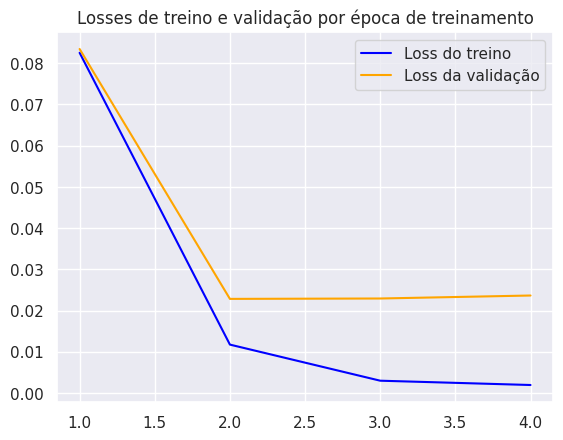

In [ ]:
def plot_train_val_losses(train_avg_losses, val_avg_losses):
  epochs = list(range(1, len(train_avg_losses)+1))
  plt.plot(epochs, train_avg_losses, color='blue', label='Loss do treino')
  plt.plot(epochs, val_avg_losses, color='orange', label='Loss da validação')
  plt.title('Losses de treino e validação por época de treinamento')
  plt.legend()

plot_train_val_losses(train_avg_losses, val_avg_losses)

# Definindo um threshold e avaliando resultados

In [ ]:
def plot_roc_curve(y_true, y_score, max_fpr=1.0):
  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  aucroc = roc_auc_score(y_true, y_score)
  plt.plot(100*fpr[fpr < max_fpr], 100*tpr[fpr < max_fpr], label=f'ROC Curve (AUC = {aucroc:.4f})')
  plt.xlim(-2,102)
  plt.xlabel('FPR (%)')
  plt.ylabel('TPR (%)')
  plt.legend()
  plt.title('ROC Curve and AUCROC')

In [ ]:
def get_tpr_per_attack(y_labels, y_pred):
  aux_df = pd.DataFrame({'Label':y_labels,'prediction':y_pred})
  total_per_label = aux_df['Label'].value_counts().to_dict()
  correct_predictions_per_label = aux_df.query('Label != "BENIGN" and prediction == True').groupby('Label').size().to_dict()
  tpr_per_attack = {}
  for attack_label, total in total_per_label.items():
    if attack_label == 'BENIGN':
      continue
    tp = correct_predictions_per_label[attack_label] if attack_label in correct_predictions_per_label else 0
    tpr = tp/total
    tpr_per_attack[attack_label] = tpr
  return tpr_per_attack

In [ ]:
def get_overall_metrics(y_true, y_pred):
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  acc = (tp+tn)/(tp+tn+fp+fn)
  tpr = tp/(tp+fn)
  fpr = fp/(fp+tn)
  precision = tp/(tp+fp)
  f1 = (2*tpr*precision)/(tpr+precision)
  return {'acc':acc,'tpr':tpr,'fpr':fpr,'precision':precision,'f1-score':f1}

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  group_counts = [f'{value:.0f}' for value in confusion_matrix(y_true, y_pred).ravel()]
  group_percentages = [f'{value*100:.2f}%' for value in confusion_matrix(y_true, y_pred).ravel()/np.sum(cm)]
  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]
  labels = np.array(labels).reshape(2,2)
  sns.heatmap(cm, annot=labels, cmap='Oranges', xticklabels=['Predicted Benign', 'Predicted Malicious'], yticklabels=['Actual Benign', 'Actual Malicious'], fmt='')
  return

# Conjunto de validação

In [ ]:
def get_autoencoder_anomaly_scores(ae_model, X):
  X = torch.FloatTensor(X)
  reconstructed_X = ae_model(X)
  anomaly_scores = torch.mean(torch.pow(X - reconstructed_X, 2), axis=1).detach().numpy() # MSELoss
  return anomaly_scores

In [ ]:
val_anomaly_scores = get_autoencoder_anomaly_scores(ae_model, norm_X_val)

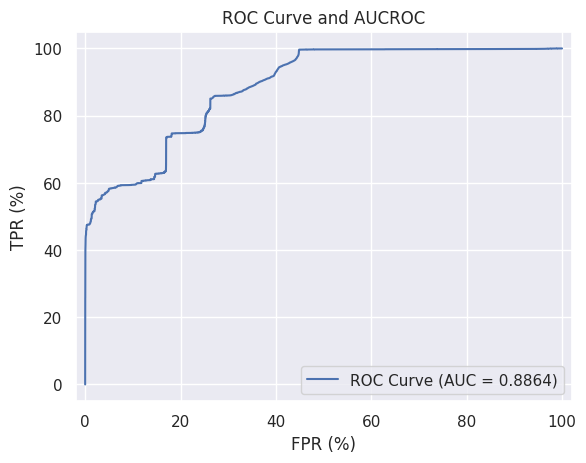

In [ ]:
plot_roc_curve(y_val, val_anomaly_scores)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, val_anomaly_scores)
df_val_roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds})
df_val_roc['youden-index'] = df_val_roc['tpr'] - df_val_roc['fpr']
df_val_roc.sort_values('youden-index', ascending=False).drop_duplicates('fpr').query('fpr < 0.03')

,fpr,tpr,thresholds,youden-index
6266,0.022337,0.544547,0.009542,0.522210
6262,0.022293,0.544480,0.009565,0.522187
6268,0.022375,0.544554,0.009525,0.522179
6270,0.022388,0.544560,0.009517,0.522172
6260,0.022289,0.544460,0.009567,0.522170
...,...,...,...,...
309,0.000014,0.071275,0.066927,0.071262
303,0.000010,0.067129,0.069320,0.067119
299,0.000007,0.065922,0.069974,0.065915
178,0.000003,0.057784,0.070998,0.057780


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['fpr'].plot(kind='hist', bins=20, title='fpr')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['tpr'].plot(kind='hist', bins=20, title='tpr')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['thresholds'].plot(kind='hist', bins=20, title='thresholds')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='index', y='fpr', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='fpr', y='tpr', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='tpr', y='thresholds', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='thresholds', y='youden-index', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['fpr'].plot(kind='line', figsize=(8, 4), title='fpr')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['tpr'].plot(kind='line', figsize=(8, 4), title='tpr')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['thresholds'].plot(kind='line', figsize=(8, 4), title='thresholds')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
BEST_VALIDATION_THRESHOLD = 0.018680

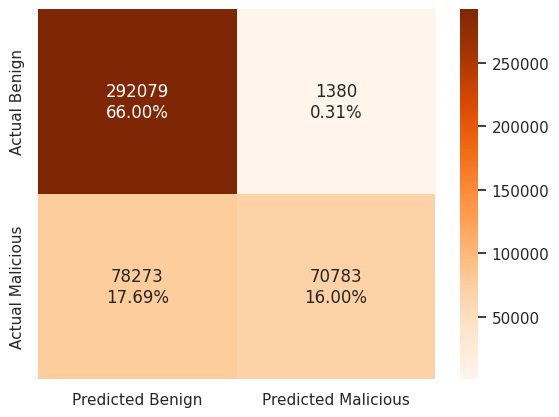

In [ ]:
plot_confusion_matrix(y_val, val_anomaly_scores > BEST_VALIDATION_THRESHOLD)

In [ ]:
get_overall_metrics(y_val, val_anomaly_scores > BEST_VALIDATION_THRESHOLD)

{'acc': 0.8199993220568794,
 'tpr': 0.4748752146844139,
 'fpr': 0.004702530847580071,
 'precision': 0.9808766265260591,
 'f1-score': 0.6399359910315117}

In [ ]:
get_tpr_per_attack(classes_val, val_anomaly_scores > BEST_VALIDATION_THRESHOLD)

{'DoS Hulk': 0.8312946310499868,
 'DDoS': 0.42802303262955854,
 'PortScan': 0.0018561046968886652,
 'DoS GoldenEye': 0.2338888888888889,
 'FTP-Patator': 0.0004816955684007707,
 'DoS slowloris': 0.21220159151193635,
 'DoS Slowhttptest': 0.004918032786885246,
 'SSH-Patator': 0.0,
 'Bot': 0.0,
 'Brute Force': 0.0,
 'XSS': 0.0,
 'Infiltration': 0.0,
 'Sql Injection': 0.0,
 'Heartbleed': 1.0}

# Conjunto de teste

In [ ]:
test_anomaly_scores = get_autoencoder_anomaly_scores(ae_model, norm_X_test)

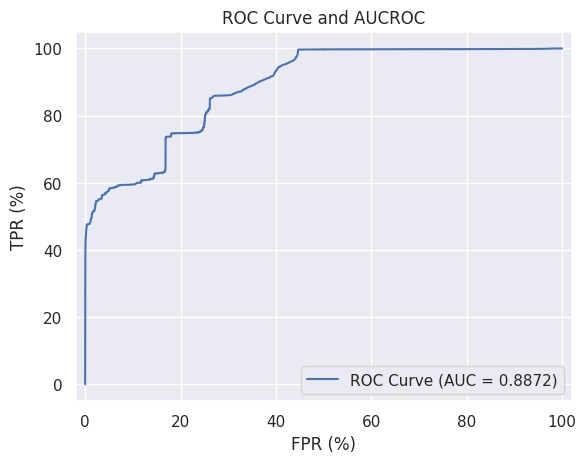

In [ ]:
plot_roc_curve(y_test, test_anomaly_scores)

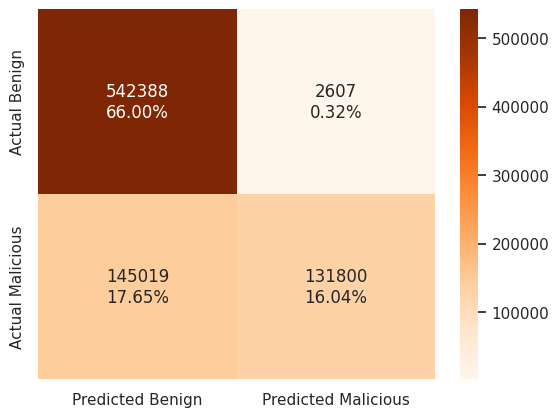

In [ ]:
plot_confusion_matrix(y_test, test_anomaly_scores > BEST_VALIDATION_THRESHOLD)

In [ ]:
get_overall_metrics(y_test, test_anomaly_scores > BEST_VALIDATION_THRESHOLD)

{'acc': 0.8203656788519057,
 'tpr': 0.4761233874842406,
 'fpr': 0.004783530124129579,
 'precision': 0.9806036887959705,
 'f1-score': 0.6410100528663071}

In [ ]:
get_tpr_per_attack(classes_test, test_anomaly_scores > BEST_VALIDATION_THRESHOLD)

{'DoS Hulk': 0.831909212283044,
 'DDoS': 0.4306453551255859,
 'PortScan': 0.0022530153137281473,
 'DoS GoldenEye': 0.24125037391564463,
 'FTP-Patator': 0.00025926886180969663,
 'DoS slowloris': 0.20885714285714285,
 'DoS Slowhttptest': 0.003237198351971748,
 'SSH-Patator': 0.0,
 'Bot': 0.003937007874015748,
 'Brute Force': 0.0,
 'XSS': 0.0,
 'Infiltration': 0.0,
 'Sql Injection': 0.0,
 'Heartbleed': 1.0}

# Pergunta e atividade

## Como um autoencoder é capaz de realizar detecção de anomalias?

  Um autoencoder é uma estrutura de depp learning que pode ser dividida em uma parte codificadora e uma parte decodificadora. A parte codificadora é responsável por reduzir a dimensionalidade dos dados, gerando uma representação de menor dimensionalidade. Por outro lado, a parte decodificadora é responsável por reconstruir os dados para dimensões próximas da original. Durante a reconstrução, a versão redimensionada dos dados, naturalmente, apresenta erros de construção, podendo ser grandes ou pequenos. Modelos que foram treinados com um determinado tipo de dado consegue realizar uma reconstrução com poucos erros, porém geram reconstruções com grandes perdas quando estão diante de dados diferentes dos que foram treinados. Sendo assim, no contexto de detecção de intrusão, podemos treinar um autoencoder com dados benignos. Como consequência, ao ser exposto a dados malignos, o autoencoder realizará reconstruções com grandes erros, tornando-o um potencial sistema de detecção de intrusão.

Insira sua resposta aqui

# Atividade de código

Autoencoders podem ter diferentes arquiteturas de redes neurais para funcionar. O autoencoder visto acima possui as seguintes camadas (representadas juntamente com suas respectivas quantidades de neurônios):

*features de entrada -> 25 neurônios -> 10 neurônios -> 25 neurônios -> 10 neurônios*

**Crie você mesmo e avalie resultados de um autoencoder com uma nova arquitetura, considerando as seguintes camadas (representadas juntamente com suas respectivas quantidades de neurônios):**

**features de entrada -> 30 neurônios -> 20 neurônios -> 10 neurônios -> 20 neurônios -> 30 neurônios -> features de entrada**



# Mecanismo de Early Stopping

In [ ]:
# Implementação do Early Stopping
class EarlyStopping:
  def __init__(self, patience=7, delta=0, verbose=True, path='checkpoint.pt'):
      self.patience = patience
      self.delta = delta
      self.verbose = verbose
      self.counter = 0
      self.early_stop = False
      self.val_min_loss = np.Inf
      self.path = path

  def __call__(self, val_loss, model):
    if val_loss < self.val_min_loss - self.delta:   # Caso a loss da validação reduza, vamos salvar o modelo e nova loss mínima
      self.save_checkpoint(val_loss, model)
      self.counter = 0
    else:                                           # Caso a loss da validação NÃO reduza, vamos incrementar o contador da paciencia
      self.counter += 1
      print(f'EarlyStopping counter: {self.counter} out of {self.patience}. Current validation loss: {val_loss:.5f}')
      if self.counter >= self.patience:
          self.early_stop = True

  def save_checkpoint(self, val_loss, model):
    if self.verbose:
        print(f'Validation loss decreased ({self.val_min_loss:.5f} --> {val_loss:.5f}).  Saving model ...')
    torch.save(model, self.path)
    self.val_min_loss = val_loss

# Autoencoder - Implementação

In [ ]:
# Implementação do Autoencoder
class Autoencoder(nn.Module):
  def __init__(self, in_features, dropout_rate=0.2):
    super().__init__()

    self.in_features = in_features
    self.dropout_rate = dropout_rate
    self.early_stopping = None
    self.encoder = nn.Sequential(
      # Camada 1 de encoding:
      nn.Linear(in_features, 30),
      nn.BatchNorm1d(30),
      nn.ReLU(),
      nn.Dropout(dropout_rate),
      # Camada 2 de encoding:
      nn.Linear(30, 20),
      nn.BatchNorm1d(20),
      nn.ReLU(),
      nn.Dropout(dropout_rate),
      # Camada 3 de encoding:
      nn.Linear(20, 10),
      nn.BatchNorm1d(10),
      nn.ReLU(),
      nn.Dropout(dropout_rate),
      # Camada 4 de encoding:
      nn.Linear(10, 20),
      nn.BatchNorm1d(20),
      nn.ReLU(),
    )

    self.decoder = nn.Sequential(
      # Camada 1 de decoding:
      nn.Linear(20, 30),
      nn.BatchNorm1d(30),
      nn.ReLU(),
      nn.Dropout(dropout_rate),
      # Camada 2 de decoding:
      nn.Linear(30, in_features),
      nn.BatchNorm1d(in_features),
      nn.Sigmoid()
    )

  def forward(self, X):
    encoded = self.encoder(X)
    decoded = self.decoder(encoded)
    return decoded

  def compile(self, learning_rate):
    self.criterion = nn.MSELoss()
    self.optimizer = optim.Adam(self.parameters(), lr = learning_rate)

  def fit(self, X_train, num_epochs, batch_size, X_val = None, patience = None, delta = None):
    if X_val is not None and patience is not None and delta is not None:
      print(f'Using early stopping with patience={patience} and delta={delta}')
      self.early_stopping = EarlyStopping(patience, delta)

    val_avg_losses = []
    train_avg_losses = []

    for epoch in range(num_epochs):
      # Calibrando os pesos do modelo
      train_losses = []
      self.train()
      for batch in tqdm(range(0, len(X_train), batch_size)):
        batch_X = X_train[batch:(batch+batch_size)]
        batch_reconstruction = self.forward(batch_X)

        train_loss = self.criterion(batch_reconstruction, batch_X)
        self.optimizer.zero_grad()
        train_loss.backward()
        self.optimizer.step()
        train_losses.append(train_loss.item())
      train_avg_loss = np.mean(train_losses)
      train_avg_losses.append(train_avg_loss)
      print(f'Epoch#{epoch+1}: Train Average Loss = {train_avg_loss:.5f}')

      # Mecanismo de early stopping
      if self.early_stopping is not None:
        val_losses = []
        self.eval()
        with torch.no_grad():
          for batch in range(0, len(X_val), batch_size):
            batch_X = X_val[batch:(batch+batch_size)]
            batch_reconstruction = self.forward(batch_X)
            val_loss = self.criterion(batch_reconstruction, batch_X)
            val_losses.append(val_loss.item())
        val_avg_loss = np.mean(val_losses)
        val_avg_losses.append(val_avg_loss)
        self.early_stopping(val_avg_loss, self)
        if self.early_stopping.early_stop:
          print(f'Stopped by early stopping at epoch {epoch+1}')
          break

    if self.early_stopping is not None:
      self = torch.load('checkpoint.pt')
    self.eval()
    return train_avg_losses, val_avg_losses

O seguinte autoencoder contem quatro camadas de encoding e duas camadas de encoding.

In [ ]:
BATCH_SIZE = 256
LR = 5e-4
PATIENCE = 2
DELTA = 0.001
NUM_EPOCHS = 3
IN_FEATURES = norm_X_train.shape[1]

In [ ]:
ae_model = Autoencoder(IN_FEATURES)
ae_model.compile(learning_rate = LR)

In [ ]:
from torchsummary import summary
summary(ae_model, (IN_FEATURES,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 30]           1,620
       BatchNorm1d-2                   [-1, 30]              60
              ReLU-3                   [-1, 30]               0
           Dropout-4                   [-1, 30]               0
            Linear-5                   [-1, 20]             620
       BatchNorm1d-6                   [-1, 20]              40
              ReLU-7                   [-1, 20]               0
           Dropout-8                   [-1, 20]               0
            Linear-9                   [-1, 10]             210
      BatchNorm1d-10                   [-1, 10]              20
             ReLU-11                   [-1, 10]               0
          Dropout-12                   [-1, 10]               0
           Linear-13                   [-1, 20]             220
      BatchNorm1d-14                   

In [ ]:
# Exemplo de treinamento sem utilizar Early Stopping

train_avg_losses, _ = ae_model.fit(torch.FloatTensor(norm_X_train), NUM_EPOCHS, BATCH_SIZE)

  0%|          | 0/4913 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.07882


  0%|          | 0/4913 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.01260


  0%|          | 0/4913 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.00395


In [ ]:
# Exemplo de treinamento utilizando Early Stopping

# Passo 1: Considerar apenas amostras benignas no conjunto de validação
benign_norm_X_val = norm_X_val[y_val == 1]
benign_norm_X_val = torch.FloatTensor(benign_norm_X_val)

# Passo 2: Realizar treinamento do modelo
NUM_EPOCHS = 10
ae_model_with_es = Autoencoder(IN_FEATURES)
ae_model_with_es.compile(learning_rate = LR)
train_avg_losses, val_avg_losses = ae_model_with_es.fit(torch.FloatTensor(norm_X_train),
                                                NUM_EPOCHS,
                                                BATCH_SIZE,
                                                X_val = benign_norm_X_val,
                                                patience=PATIENCE,
                                                delta=DELTA)

Using early stopping with patience=2 and delta=0.001


  0%|          | 0/4913 [00:00<?, ?it/s]

Epoch#1: Train Average Loss = 0.07910
Validation loss decreased (inf --> 0.03128).  Saving model ...


  0%|          | 0/4913 [00:00<?, ?it/s]

Epoch#2: Train Average Loss = 0.01083
Validation loss decreased (0.03128 --> 0.02340).  Saving model ...


  0%|          | 0/4913 [00:00<?, ?it/s]

Epoch#3: Train Average Loss = 0.00369
Validation loss decreased (0.02340 --> 0.02184).  Saving model ...


  0%|          | 0/4913 [00:00<?, ?it/s]

Epoch#4: Train Average Loss = 0.00290
EarlyStopping counter: 1 out of 2. Current validation loss: 0.02267


  0%|          | 0/4913 [00:00<?, ?it/s]

Epoch#5: Train Average Loss = 0.00266
EarlyStopping counter: 2 out of 2. Current validation loss: 0.02267
Stopped by early stopping at epoch 5


Abaixo podemos ver um gráfico que exibe as losses (perdas) de treino e validação ao longo das épocas de treinamento. As losses são medidas que indicam quão bem o modelo está aprendendo a tarefa específica para a qual foi treinado. Esse gráfico nos possibilita:

- Acompanhar o treinamento
- Detectar overfitting
- Visualizar a convergência do modelo

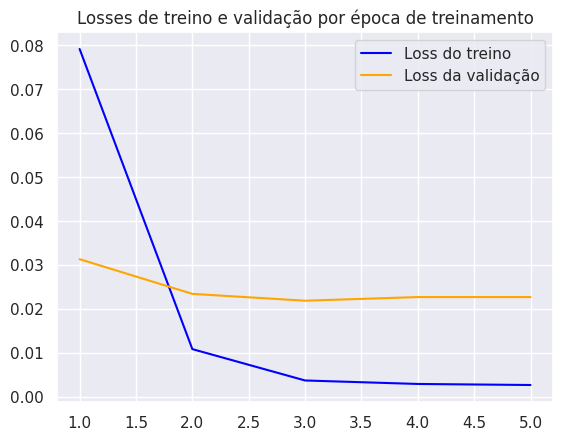

In [ ]:
def plot_train_val_losses(train_avg_losses, val_avg_losses):
  epochs = list(range(1, len(train_avg_losses)+1))
  plt.plot(epochs, train_avg_losses, color='blue', label='Loss do treino')
  plt.plot(epochs, val_avg_losses, color='orange', label='Loss da validação')
  plt.title('Losses de treino e validação por época de treinamento')
  plt.legend()

plot_train_val_losses(train_avg_losses, val_avg_losses)

Aqui percebemos que a loss de validação se manteve quase que constante. Enquanto isso, a loss de treino bastante com o passar das épocas, revelando um bom aprendizado.

# Definindo um threshold e avaliando resultados

In [ ]:
def plot_roc_curve(y_true, y_score, max_fpr=1.0):
  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  aucroc = roc_auc_score(y_true, y_score)
  plt.plot(100*fpr[fpr < max_fpr], 100*tpr[fpr < max_fpr], label=f'ROC Curve (AUC = {aucroc:.4f})')
  plt.xlim(-2,102)
  plt.xlabel('FPR (%)')
  plt.ylabel('TPR (%)')
  plt.legend()
  plt.title('ROC Curve and AUCROC')

In [ ]:
def get_tpr_per_attack(y_labels, y_pred):
  aux_df = pd.DataFrame({'Label':y_labels,'prediction':y_pred})
  total_per_label = aux_df['Label'].value_counts().to_dict()
  correct_predictions_per_label = aux_df.query('Label != "BENIGN" and prediction == True').groupby('Label').size().to_dict()
  tpr_per_attack = {}
  for attack_label, total in total_per_label.items():
    if attack_label == 'BENIGN':
      continue
    tp = correct_predictions_per_label[attack_label] if attack_label in correct_predictions_per_label else 0
    tpr = tp/total
    tpr_per_attack[attack_label] = tpr
  return tpr_per_attack

In [ ]:
def get_overall_metrics(y_true, y_pred):
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  acc = (tp+tn)/(tp+tn+fp+fn)
  tpr = tp/(tp+fn)
  fpr = fp/(fp+tn)
  precision = tp/(tp+fp)
  f1 = (2*tpr*precision)/(tpr+precision)
  return {'acc':acc,'tpr':tpr,'fpr':fpr,'precision':precision,'f1-score':f1}

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  group_counts = [f'{value:.0f}' for value in confusion_matrix(y_true, y_pred).ravel()]
  group_percentages = [f'{value*100:.2f}%' for value in confusion_matrix(y_true, y_pred).ravel()/np.sum(cm)]
  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]
  labels = np.array(labels).reshape(2,2)
  sns.heatmap(cm, annot=labels, cmap='Oranges', xticklabels=['Predicted Benign', 'Predicted Malicious'], yticklabels=['Actual Benign', 'Actual Malicious'], fmt='')
  return

# Conjunto de validação

In [ ]:
def get_autoencoder_anomaly_scores(ae_model, X):
  X = torch.FloatTensor(X)
  reconstructed_X = ae_model(X)
  anomaly_scores = torch.mean(torch.pow(X - reconstructed_X, 2), axis=1).detach().numpy() # MSELoss
  return anomaly_scores

In [ ]:
val_anomaly_scores = get_autoencoder_anomaly_scores(ae_model, norm_X_val)

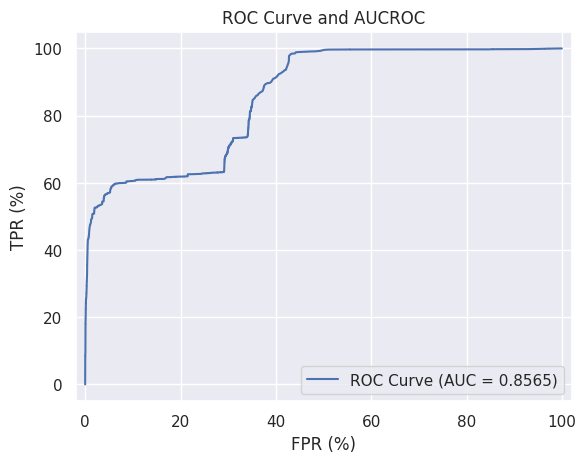

In [ ]:
plot_roc_curve(y_val, val_anomaly_scores)

A curva ROC dessa arquitetura de autoencoder apresentou um AUC menor que da arquitetura presente no começo do colab

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, val_anomaly_scores)
df_val_roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds})
df_val_roc['youden-index'] = df_val_roc['tpr'] - df_val_roc['fpr']
df_val_roc.sort_values('youden-index', ascending=False).drop_duplicates('fpr').query('fpr < 0.03')

,fpr,tpr,thresholds,youden-index
9937,0.024596,0.484046,0.018919,0.459450
9941,0.024620,0.484066,0.018903,0.459446
9935,0.024586,0.484026,0.018924,0.459440
9939,0.024617,0.484053,0.018905,0.459436
9933,0.024576,0.484006,0.018930,0.459430
...,...,...,...,...
135,0.000014,0.046855,0.077346,0.046841
126,0.000010,0.044903,0.079990,0.044892
122,0.000007,0.043017,0.081234,0.043011
118,0.000003,0.040817,0.082489,0.040813


In [ ]:
BEST_VALIDATION_THRESHOLD = 0.018919

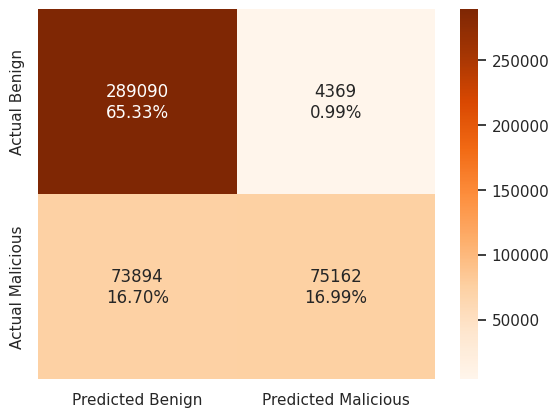

In [ ]:
plot_confusion_matrix(y_val, val_anomaly_scores > BEST_VALIDATION_THRESHOLD)

Aqui percebemos uma quantidade maior de verdadeiros negativos em relação a arquitetura anterior, contudo a arquitetura apresenta uma maior quantidade de falsos positivos e negativos, além de ter uma diminuição no número de verdadeiros positivos.

In [ ]:
get_overall_metrics(y_val, val_anomaly_scores > BEST_VALIDATION_THRESHOLD)

{'acc': 0.8271629210309255,
 'tpr': 0.5262317518248175,
 'fpr': 0.019985756102215303,
 'precision': 0.9304295220810648,
 'f1-score': 0.6722517665913892}

Nas métricas em geral, houveram melhorias na acurácia, taxa de verdadeiro/falso positivo e recall, contudo a precisão diminuiu.

In [ ]:
get_tpr_per_attack(classes_val, val_anomaly_scores > BEST_VALIDATION_THRESHOLD)

{'DoS Hulk': 0.8823393282200476,
 'DDoS': 0.5052671517207517,
 'PortScan': 0.0025167521313744614,
 'DoS GoldenEye': 0.37777777777777777,
 'FTP-Patator': 0.0004816955684007707,
 'DoS slowloris': 0.24880636604774536,
 'DoS Slowhttptest': 0.26994535519125684,
 'SSH-Patator': 0.0,
 'Bot': 0.017569546120058566,
 'Brute Force': 0.0,
 'XSS': 0.0,
 'Infiltration': 0.07692307692307693,
 'Sql Injection': 0.0,
 'Heartbleed': 1.0}

 Na questão de taxa de verdadeiro positivos na detecção de determinadas classes de ataque, houveram melhorias na capacidade de detecção, porém tivemos uma leve piora na detecção das classes "PortScan", "DoS slowloris" e "DoS Slowhttptest". É válido postular que a nova arquitetura desevolveu a capacidade de detectar ameaças da classes "Bot".

# Conjunto de teste

In [ ]:
test_anomaly_scores = get_autoencoder_anomaly_scores(ae_model, norm_X_test)

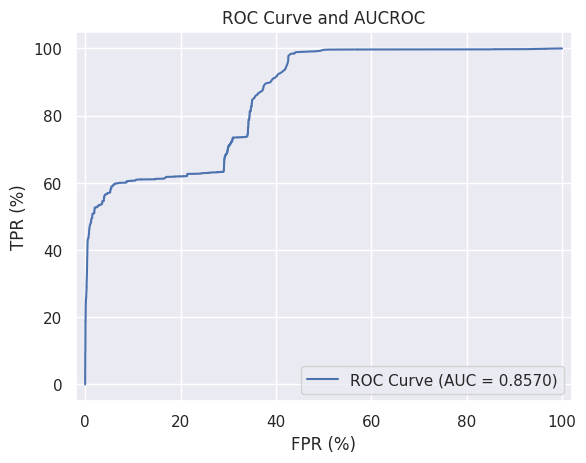

In [ ]:
plot_roc_curve(y_test, test_anomaly_scores)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, val_anomaly_scores)
df_val_roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds})
df_val_roc['youden-index'] = df_val_roc['tpr'] - df_val_roc['fpr']
df_val_roc.sort_values('youden-index', ascending=False).drop_duplicates('fpr').query('fpr < 0.03')

,fpr,tpr,thresholds,youden-index
8345,0.019866,0.526198,0.018209,0.506332
8347,0.019873,0.526205,0.018209,0.506332
8353,0.019897,0.526225,0.018209,0.506328
8351,0.019894,0.526218,0.018209,0.506325
8343,0.019863,0.526185,0.018209,0.506322
...,...,...,...,...
600,0.000031,0.031840,0.073097,0.031810
598,0.000020,0.031773,0.073199,0.031753
590,0.000007,0.031411,0.073550,0.031404
578,0.000003,0.025769,0.080978,0.025765


In [ ]:
BEST_VALIDATION_THRESHOLD = 0.018209

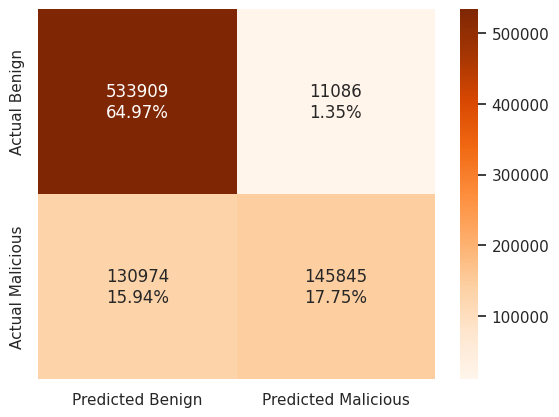

In [ ]:
plot_confusion_matrix(y_test, test_anomaly_scores > BEST_VALIDATION_THRESHOLD)

Na curva ROC, tivemos uma melhoria na quantidade de verdadeiros positivos/negativos. Tmabém tivemos uma redução no número de falsos positivos e falsos negativos.

In [ ]:
get_overall_metrics(y_test, test_anomaly_scores > BEST_VALIDATION_THRESHOLD)

{'acc': 0.8271385009260003,
 'tpr': 0.5268605117423298,
 'fpr': 0.020341471022669932,
 'precision': 0.9293574883228936,
 'f1-score': 0.6724841498559078}

Nas métricas em geral, houveram melhorias na acurácia, taxa de verdadeiro/falso positivo e recall, contudo a precisão diminuiu.

In [ ]:
get_tpr_per_attack(classes_test, test_anomaly_scores > BEST_VALIDATION_THRESHOLD)

{'DoS Hulk': 0.8823587004895416,
 'DDoS': 0.5070784761446941,
 'PortScan': 0.003116953516736685,
 'DoS GoldenEye': 0.38872270415794197,
 'FTP-Patator': 0.00025926886180969663,
 'DoS slowloris': 0.2402857142857143,
 'DoS Slowhttptest': 0.25103001765744554,
 'SSH-Patator': 0.0,
 'Bot': 0.01889763779527559,
 'Brute Force': 0.0,
 'XSS': 0.0,
 'Infiltration': 0.391304347826087,
 'Sql Injection': 0.0,
 'Heartbleed': 1.0}

 Na questão de taxa de verdadeiro positivos na detecção de determinadas classes de ataque, Houveram melhoras em todas as métricas, em relação a arquitetura anterior. Inclusive, a arquitetura passou a reconhecer ameaças da classe "Inflitration".